# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [14]:
%run -i 'cosim_import.py'

0.post4479.dev0+g94184ca
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [15]:
caseH = 18
ict_off = True
ecc_off = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=433.49 MWh
Online 14439, Q=361.0 MWh, SoC=0.7685
Power(MW): Pt=-39.7925, Pc=-39.7925, Pd=-0.0
Ctrl: 0=7733; 1=6706; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.4377 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1186 seconds.
System internal structure set up in 0.0638 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


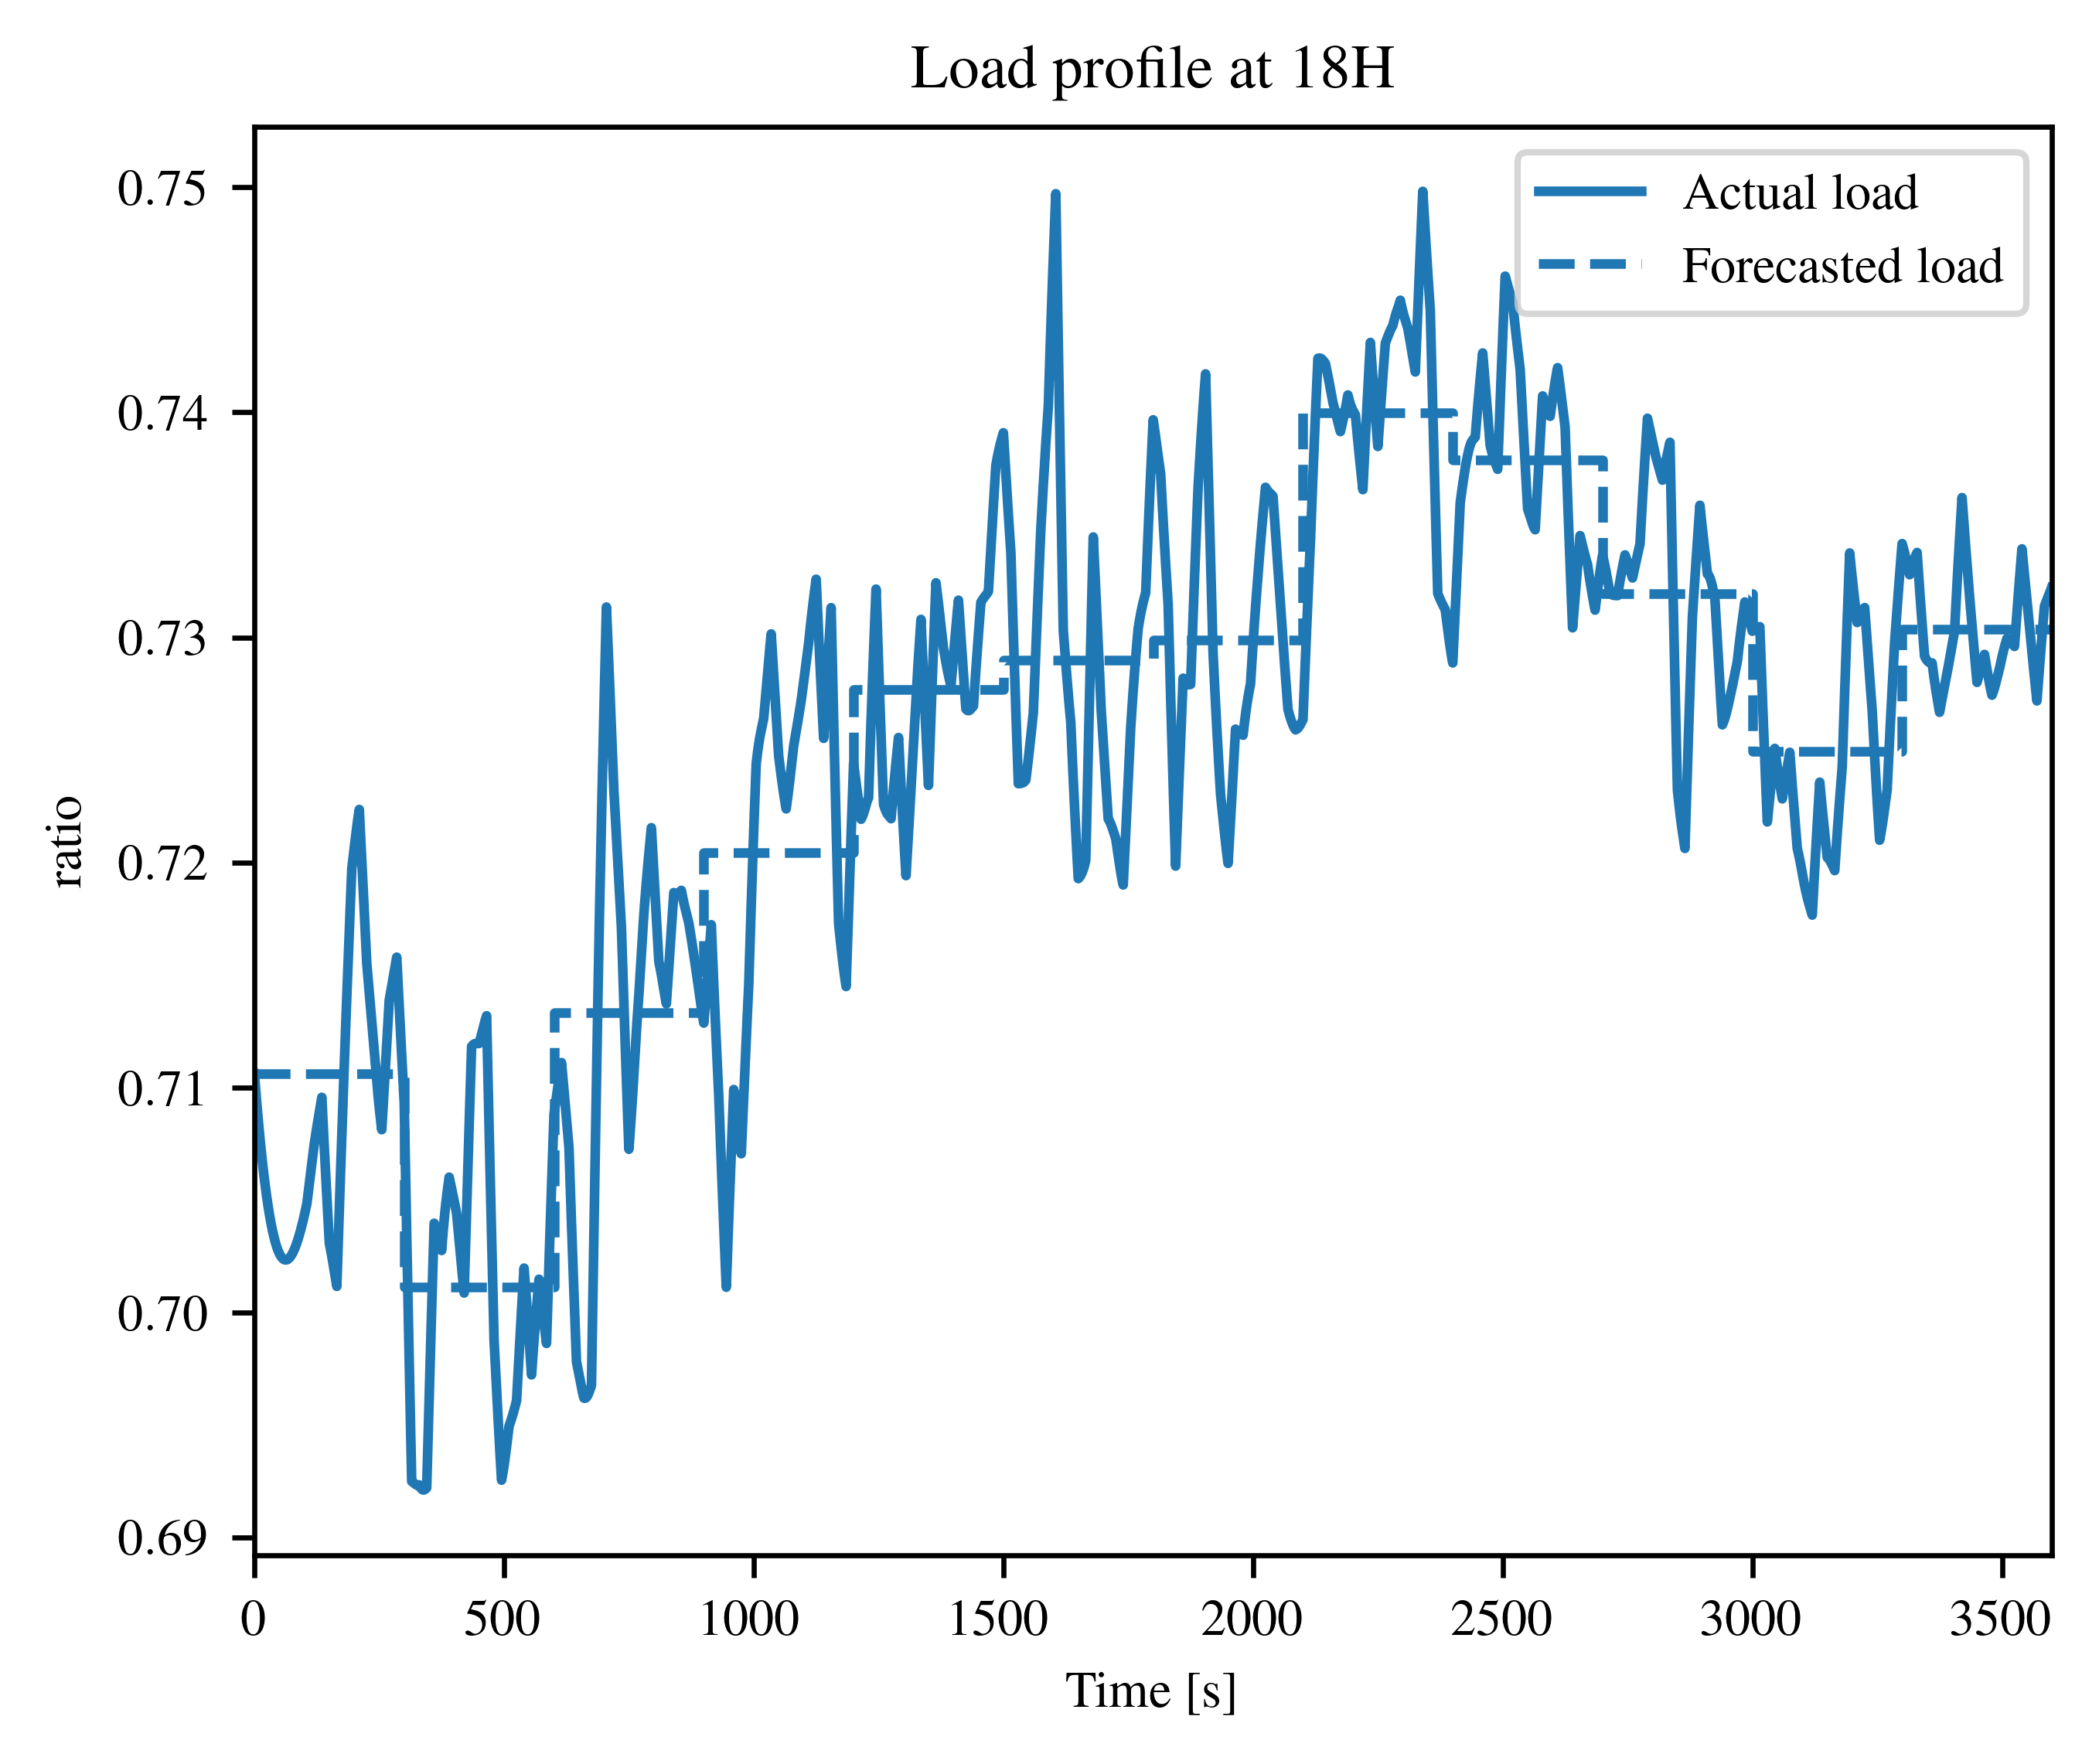

In [16]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [17]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0861 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917096747
2: |F(x)| = 0.1313034816
3: |F(x)| = 0.0003572030639
4: |F(x)| = 4.286551558e-09
Converged in 5 iterations in 0.0179 seconds.
Power flow results are consistent. Conversion is successful.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0171 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917096747
2: |F(x)| = 0.1313034816
3: |F(x)| = 0.0003

pp cost=2224.7878007021177, gb cost=4910.261740428772


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,1002.7465,90.1808,15.9216,1.0,1002.7465
1,646.0000,310.9539,1.9541,1.0,646.0000
2,290.0000,148.8148,-1.1566,1.0,290.0000
3,652.0000,129.6589,6.9368,1.0,652.0000
4,508.0000,145.0392,5.1055,1.0,508.0000
5,668.4976,225.0970,6.4635,1.0,668.4977
6,232.0000,60.4674,3.2564,1.0,232.0000
7,564.0000,-26.0145,13.4722,1.0,564.0000
8,865.0000,115.3272,15.9301,1.0,865.0000
9,-39.7925,0.0000,15.9301,1.0,-39.7925


## Prepare

### Make link table

In [18]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [19]:
ssa.TGOV1N.as_df()

,idx,u,name,syn,Tn,wref0,R,VMAX,VMIN,T1,T2,T3,Dt
uid,,,,,,,,,,,,,
0,TGOV1_1,1.0,TGOV1_1,GENROU_1,1040.0,1.0,0.004808,14.5600,0.0,0.8,1.0,2.1,0.0
1,TGOV1_2,1.0,TGOV1_2,GENROU_2,836.0,1.0,0.005981,11.7040,0.0,0.8,1.0,2.1,0.0
2,TGOV1_3,1.0,TGOV1_3,GENROU_3,843.7,1.0,0.005926,11.8118,0.0,0.8,1.0,2.1,0.0
3,TGOV1_4,1.0,TGOV1_4,GENROU_4,1174.8,1.0,0.004256,16.4472,0.0,0.8,1.0,2.1,0.0
4,TGOV1_5,1.0,TGOV1_5,GENROU_5,1080.2,1.0,0.004629,15.1228,0.0,0.8,1.0,2.1,0.0
5,TGOV1_6,1.0,TGOV1_6,GENROU_6,1085.7,1.0,0.004605,15.1998,0.0,0.8,1.0,2.1,0.0
6,TGOV1_7,1.0,TGOV1_7,GENROU_7,1025.2,1.0,0.004877,14.3528,0.0,0.8,1.0,2.1,0.0
7,TGOV1_8,1.0,TGOV1_8,GENROU_8,970.2,1.0,0.005154,13.5828,0.0,0.8,1.0,2.1,0.0
8,TGOV1_9,1.0,TGOV1_9,GENROU_9,1684.1,1.0,0.002969,23.5774,0.0,0.8,1.0,2.1,0.0


In [20]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [21]:
%run -i 'cosim_bmain.py'

RTED removed: ['rampu', 'rampd']


RTED not solved:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
They run into: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Loop

In [ ]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4565.434
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0099 seconds.
0: |F(x)| = 7.80582491
1: |F(x)| = 3.745701393
2: |F(x)| = 0.248746692
3: |F(x)| = 0.002035933613
4: |F(x)| = 9.556706049e-08
Converged in 5 iterations in 0.0131 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for d

Simulation to t=124.00 sec completed in 0.0845 seconds.
Simulation to t=125.00 sec completed in 0.0800 seconds.
Simulation to t=126.00 sec completed in 0.0813 seconds.
Simulation to t=127.00 sec completed in 0.0797 seconds.
Simulation to t=128.00 sec completed in 0.0866 seconds.
Simulation to t=129.00 sec completed in 0.0844 seconds.
Simulation to t=130.00 sec completed in 0.0834 seconds.
Simulation to t=131.00 sec completed in 0.0832 seconds.
Simulation to t=132.00 sec completed in 0.0831 seconds.
Simulation to t=133.00 sec completed in 0.0893 seconds.
Simulation to t=134.00 sec completed in 0.0830 seconds.
Simulation to t=135.00 sec completed in 0.0857 seconds.
Simulation to t=136.00 sec completed in 0.1253 seconds.
Simulation to t=137.00 sec completed in 0.0813 seconds.
Simulation to t=138.00 sec completed in 0.0820 seconds.
Simulation to t=139.00 sec completed in 0.0785 seconds.
Simulation to t=140.00 sec completed in 0.0789 seconds.
Simulation to t=141.00 sec completed in 0.0835 s

Simulation to t=271.00 sec completed in 0.0779 seconds.
Simulation to t=272.00 sec completed in 0.0772 seconds.
Simulation to t=273.00 sec completed in 0.0807 seconds.
Simulation to t=274.00 sec completed in 0.0808 seconds.
Simulation to t=275.00 sec completed in 0.0762 seconds.
Simulation to t=276.00 sec completed in 0.0758 seconds.
Simulation to t=277.00 sec completed in 0.0784 seconds.
Simulation to t=278.00 sec completed in 0.0755 seconds.
Simulation to t=279.00 sec completed in 0.0813 seconds.
Simulation to t=280.00 sec completed in 0.0752 seconds.
Simulation to t=281.00 sec completed in 0.0771 seconds.
Simulation to t=282.00 sec completed in 0.0785 seconds.
Simulation to t=283.00 sec completed in 0.0777 seconds.
Simulation to t=284.00 sec completed in 0.0783 seconds.
Simulation to t=285.00 sec completed in 0.0764 seconds.
Simulation to t=286.00 sec completed in 0.0805 seconds.
Simulation to t=287.00 sec completed in 0.0792 seconds.
Simulation to t=288.00 sec completed in 0.0775 s

Simulation to t=417.00 sec completed in 0.0747 seconds.
Simulation to t=418.00 sec completed in 0.0747 seconds.
Simulation to t=419.00 sec completed in 0.0770 seconds.
Simulation to t=420.00 sec completed in 0.0764 seconds.
Simulation to t=421.00 sec completed in 0.0780 seconds.
Simulation to t=422.00 sec completed in 0.0780 seconds.
Simulation to t=423.00 sec completed in 0.0788 seconds.
Simulation to t=424.00 sec completed in 0.0793 seconds.
Simulation to t=425.00 sec completed in 0.0786 seconds.
Simulation to t=426.00 sec completed in 0.0757 seconds.
Simulation to t=427.00 sec completed in 0.0796 seconds.
Simulation to t=428.00 sec completed in 0.0784 seconds.
Simulation to t=429.00 sec completed in 0.0755 seconds.
Simulation to t=430.00 sec completed in 0.0774 seconds.
Simulation to t=431.00 sec completed in 0.0760 seconds.
Simulation to t=432.00 sec completed in 0.0915 seconds.
Simulation to t=433.00 sec completed in 0.0879 seconds.
Simulation to t=434.00 sec completed in 0.0775 s

Simulation to t=564.00 sec completed in 0.0818 seconds.
Simulation to t=565.00 sec completed in 0.0764 seconds.
Simulation to t=566.00 sec completed in 0.0768 seconds.
Simulation to t=567.00 sec completed in 0.0792 seconds.
Simulation to t=568.00 sec completed in 0.0826 seconds.
Simulation to t=569.00 sec completed in 0.0809 seconds.
Simulation to t=570.00 sec completed in 0.0860 seconds.
Simulation to t=571.00 sec completed in 0.0815 seconds.
Simulation to t=572.00 sec completed in 0.0850 seconds.
Simulation to t=573.00 sec completed in 0.0788 seconds.
Simulation to t=574.00 sec completed in 0.0807 seconds.
Simulation to t=575.00 sec completed in 0.0808 seconds.
Simulation to t=576.00 sec completed in 0.0812 seconds.
Simulation to t=577.00 sec completed in 0.0787 seconds.
Simulation to t=578.00 sec completed in 0.0828 seconds.
Simulation to t=579.00 sec completed in 0.0793 seconds.
Simulation to t=580.00 sec completed in 0.0774 seconds.
Simulation to t=581.00 sec completed in 0.0819 s

Simulation to t=710.00 sec completed in 0.1128 seconds.
Simulation to t=711.00 sec completed in 0.0994 seconds.
Simulation to t=712.00 sec completed in 0.0879 seconds.
Simulation to t=713.00 sec completed in 0.0839 seconds.
Simulation to t=714.00 sec completed in 0.0974 seconds.
Simulation to t=715.00 sec completed in 0.0839 seconds.
Simulation to t=716.00 sec completed in 0.0838 seconds.
Simulation to t=717.00 sec completed in 0.0851 seconds.
Simulation to t=718.00 sec completed in 0.0844 seconds.
Simulation to t=719.00 sec completed in 0.0852 seconds.
Simulation to t=720.00 sec completed in 0.1073 seconds.
Simulation to t=721.00 sec completed in 0.0855 seconds.
Simulation to t=722.00 sec completed in 0.0823 seconds.
Simulation to t=723.00 sec completed in 0.0874 seconds.
Simulation to t=724.00 sec completed in 0.0984 seconds.
Simulation to t=725.00 sec completed in 0.0915 seconds.
Simulation to t=726.00 sec completed in 0.0850 seconds.
Simulation to t=727.00 sec completed in 0.0846 s

Simulation to t=857.00 sec completed in 0.0873 seconds.
Simulation to t=858.00 sec completed in 0.0782 seconds.
Simulation to t=859.00 sec completed in 0.0833 seconds.
Simulation to t=860.00 sec completed in 0.0790 seconds.
Simulation to t=861.00 sec completed in 0.0846 seconds.
Simulation to t=862.00 sec completed in 0.0801 seconds.
Simulation to t=863.00 sec completed in 0.0794 seconds.
Simulation to t=864.00 sec completed in 0.0805 seconds.
Simulation to t=865.00 sec completed in 0.0783 seconds.
Simulation to t=866.00 sec completed in 0.0798 seconds.
Simulation to t=867.00 sec completed in 0.0785 seconds.
Simulation to t=868.00 sec completed in 0.0836 seconds.
Simulation to t=869.00 sec completed in 0.0903 seconds.
Simulation to t=870.00 sec completed in 0.0894 seconds.
Simulation to t=871.00 sec completed in 0.0976 seconds.
Simulation to t=872.00 sec completed in 0.0813 seconds.
Simulation to t=873.00 sec completed in 0.0793 seconds.
Simulation to t=874.00 sec completed in 0.0810 s

Simulation to t=1003.00 sec completed in 0.0825 seconds.
Simulation to t=1004.00 sec completed in 0.0970 seconds.
Simulation to t=1005.00 sec completed in 0.0860 seconds.
Simulation to t=1006.00 sec completed in 0.0800 seconds.
Simulation to t=1007.00 sec completed in 0.0828 seconds.
Simulation to t=1008.00 sec completed in 0.1164 seconds.
Simulation to t=1009.00 sec completed in 0.0924 seconds.
Simulation to t=1010.00 sec completed in 0.0802 seconds.
Simulation to t=1011.00 sec completed in 0.0823 seconds.
Simulation to t=1012.00 sec completed in 0.0927 seconds.
Simulation to t=1013.00 sec completed in 0.0841 seconds.
Simulation to t=1014.00 sec completed in 0.0804 seconds.
Simulation to t=1015.00 sec completed in 0.0795 seconds.
Simulation to t=1016.00 sec completed in 0.0924 seconds.
Simulation to t=1017.00 sec completed in 0.0813 seconds.
Simulation to t=1018.00 sec completed in 0.0792 seconds.
Simulation to t=1019.00 sec completed in 0.0789 seconds.
Simulation to t=1020.00 sec com

Simulation to t=1147.00 sec completed in 0.0844 seconds.
Simulation to t=1148.00 sec completed in 0.0846 seconds.
Simulation to t=1149.00 sec completed in 0.0834 seconds.
Simulation to t=1150.00 sec completed in 0.0803 seconds.
Simulation to t=1151.00 sec completed in 0.0836 seconds.
Simulation to t=1152.00 sec completed in 0.0869 seconds.
Simulation to t=1153.00 sec completed in 0.0814 seconds.
Simulation to t=1154.00 sec completed in 0.0870 seconds.
Simulation to t=1155.00 sec completed in 0.0841 seconds.
Simulation to t=1156.00 sec completed in 0.1108 seconds.
Simulation to t=1157.00 sec completed in 0.0899 seconds.
Simulation to t=1158.00 sec completed in 0.0871 seconds.
Simulation to t=1159.00 sec completed in 0.0889 seconds.
Simulation to t=1160.00 sec completed in 0.1026 seconds.
Simulation to t=1161.00 sec completed in 0.0814 seconds.
Simulation to t=1162.00 sec completed in 0.0836 seconds.
Simulation to t=1163.00 sec completed in 0.0822 seconds.
Simulation to t=1164.00 sec com

Simulation to t=1290.00 sec completed in 0.0810 seconds.
Simulation to t=1291.00 sec completed in 0.0803 seconds.
Simulation to t=1292.00 sec completed in 0.0846 seconds.
Simulation to t=1293.00 sec completed in 0.0810 seconds.
Simulation to t=1294.00 sec completed in 0.0821 seconds.
Simulation to t=1295.00 sec completed in 0.0911 seconds.
Simulation to t=1296.00 sec completed in 0.0827 seconds.
Simulation to t=1297.00 sec completed in 0.0821 seconds.
Simulation to t=1298.00 sec completed in 0.0804 seconds.
Simulation to t=1299.00 sec completed in 0.0835 seconds.
Simulation to t=1300.00 sec completed in 0.0821 seconds.
Simulation to t=1301.00 sec completed in 0.0841 seconds.
Simulation to t=1302.00 sec completed in 0.0818 seconds.
Simulation to t=1303.00 sec completed in 0.0833 seconds.
Simulation to t=1304.00 sec completed in 0.0804 seconds.
Simulation to t=1305.00 sec completed in 0.0780 seconds.
Simulation to t=1306.00 sec completed in 0.0822 seconds.
Simulation to t=1307.00 sec com

Simulation to t=1434.00 sec completed in 0.0816 seconds.
Simulation to t=1435.00 sec completed in 0.0815 seconds.
Simulation to t=1436.00 sec completed in 0.0915 seconds.
Simulation to t=1437.00 sec completed in 0.0790 seconds.
Simulation to t=1438.00 sec completed in 0.0884 seconds.
Simulation to t=1439.00 sec completed in 0.0787 seconds.
Simulation to t=1440.00 sec completed in 0.0810 seconds.
Simulation to t=1441.00 sec completed in 0.0839 seconds.
Simulation to t=1442.00 sec completed in 0.0854 seconds.
Simulation to t=1443.00 sec completed in 0.0845 seconds.
Simulation to t=1444.00 sec completed in 0.0814 seconds.
Simulation to t=1445.00 sec completed in 0.0830 seconds.
Simulation to t=1446.00 sec completed in 0.0854 seconds.
Simulation to t=1447.00 sec completed in 0.0880 seconds.
Simulation to t=1448.00 sec completed in 0.0844 seconds.
Simulation to t=1449.00 sec completed in 0.0841 seconds.
Simulation to t=1450.00 sec completed in 0.0832 seconds.
Simulation to t=1451.00 sec com

Simulation to t=1577.00 sec completed in 0.0827 seconds.
Simulation to t=1578.00 sec completed in 0.0904 seconds.
Simulation to t=1579.00 sec completed in 0.1178 seconds.
Simulation to t=1580.00 sec completed in 0.0831 seconds.
Simulation to t=1581.00 sec completed in 0.0837 seconds.
Simulation to t=1582.00 sec completed in 0.0812 seconds.
Simulation to t=1583.00 sec completed in 0.0802 seconds.
Simulation to t=1584.00 sec completed in 0.0794 seconds.
Simulation to t=1585.00 sec completed in 0.0811 seconds.
Simulation to t=1586.00 sec completed in 0.0781 seconds.
Simulation to t=1587.00 sec completed in 0.0843 seconds.
Simulation to t=1588.00 sec completed in 0.0834 seconds.
Simulation to t=1589.00 sec completed in 0.0806 seconds.
Simulation to t=1590.00 sec completed in 0.0793 seconds.
Simulation to t=1591.00 sec completed in 0.0810 seconds.
Simulation to t=1592.00 sec completed in 0.0798 seconds.
Simulation to t=1593.00 sec completed in 0.0850 seconds.
Simulation to t=1594.00 sec com

Simulation to t=1721.00 sec completed in 0.0831 seconds.
Simulation to t=1722.00 sec completed in 0.0834 seconds.
Simulation to t=1723.00 sec completed in 0.0832 seconds.
Simulation to t=1724.00 sec completed in 0.0799 seconds.
Simulation to t=1725.00 sec completed in 0.0803 seconds.
Simulation to t=1726.00 sec completed in 0.0778 seconds.
Simulation to t=1727.00 sec completed in 0.0823 seconds.
Simulation to t=1728.00 sec completed in 0.0834 seconds.
Simulation to t=1729.00 sec completed in 0.0783 seconds.
Simulation to t=1730.00 sec completed in 0.0811 seconds.
Simulation to t=1731.00 sec completed in 0.0804 seconds.
Simulation to t=1732.00 sec completed in 0.0777 seconds.
Simulation to t=1733.00 sec completed in 0.0817 seconds.
Simulation to t=1734.00 sec completed in 0.0822 seconds.
Simulation to t=1735.00 sec completed in 0.0767 seconds.
Simulation to t=1736.00 sec completed in 0.0836 seconds.
Simulation to t=1737.00 sec completed in 0.0831 seconds.
Simulation to t=1738.00 sec com

Simulation to t=1864.00 sec completed in 0.0763 seconds.
Simulation to t=1865.00 sec completed in 0.0824 seconds.
Simulation to t=1866.00 sec completed in 0.0812 seconds.
Simulation to t=1867.00 sec completed in 0.0832 seconds.
Simulation to t=1868.00 sec completed in 0.0838 seconds.
Simulation to t=1869.00 sec completed in 0.0804 seconds.
Simulation to t=1870.00 sec completed in 0.0825 seconds.
Simulation to t=1871.00 sec completed in 0.0826 seconds.
Simulation to t=1872.00 sec completed in 0.0807 seconds.
Simulation to t=1873.00 sec completed in 0.0799 seconds.
Simulation to t=1874.00 sec completed in 0.0790 seconds.
Simulation to t=1875.00 sec completed in 0.0800 seconds.
Simulation to t=1876.00 sec completed in 0.0844 seconds.
Simulation to t=1877.00 sec completed in 0.0862 seconds.
Simulation to t=1878.00 sec completed in 0.0834 seconds.
Simulation to t=1879.00 sec completed in 0.0831 seconds.
Simulation to t=1880.00 sec completed in 0.0816 seconds.
Simulation to t=1881.00 sec com

Simulation to t=2008.00 sec completed in 0.0893 seconds.
Simulation to t=2009.00 sec completed in 0.0814 seconds.
Simulation to t=2010.00 sec completed in 0.0828 seconds.
Simulation to t=2011.00 sec completed in 0.0793 seconds.
Simulation to t=2012.00 sec completed in 0.0786 seconds.
Simulation to t=2013.00 sec completed in 0.0852 seconds.
Simulation to t=2014.00 sec completed in 0.0847 seconds.
Simulation to t=2015.00 sec completed in 0.0810 seconds.
Simulation to t=2016.00 sec completed in 0.0827 seconds.
Simulation to t=2017.00 sec completed in 0.0789 seconds.
Simulation to t=2018.00 sec completed in 0.0814 seconds.
Simulation to t=2019.00 sec completed in 0.0811 seconds.
Simulation to t=2020.00 sec completed in 0.0791 seconds.
Simulation to t=2021.00 sec completed in 0.0785 seconds.
Simulation to t=2022.00 sec completed in 0.0914 seconds.
Simulation to t=2023.00 sec completed in 0.0811 seconds.
Simulation to t=2024.00 sec completed in 0.0820 seconds.
Simulation to t=2025.00 sec com

Simulation to t=2151.00 sec completed in 0.0819 seconds.
Simulation to t=2152.00 sec completed in 0.0834 seconds.
Simulation to t=2153.00 sec completed in 0.0825 seconds.
Simulation to t=2154.00 sec completed in 0.0795 seconds.
Simulation to t=2155.00 sec completed in 0.0799 seconds.
Simulation to t=2156.00 sec completed in 0.0839 seconds.
Simulation to t=2157.00 sec completed in 0.0824 seconds.
Simulation to t=2158.00 sec completed in 0.0825 seconds.
Simulation to t=2159.00 sec completed in 0.0779 seconds.
Simulation to t=2160.00 sec completed in 0.0830 seconds.
Simulation to t=2161.00 sec completed in 0.0809 seconds.
Simulation to t=2162.00 sec completed in 0.0824 seconds.
Simulation to t=2163.00 sec completed in 0.0793 seconds.
Simulation to t=2164.00 sec completed in 0.0793 seconds.
Simulation to t=2165.00 sec completed in 0.0813 seconds.
Simulation to t=2166.00 sec completed in 0.0778 seconds.
Simulation to t=2167.00 sec completed in 0.0804 seconds.
Simulation to t=2168.00 sec com

Simulation to t=2295.00 sec completed in 0.0800 seconds.
Simulation to t=2296.00 sec completed in 0.1247 seconds.
Simulation to t=2297.00 sec completed in 0.0839 seconds.
Simulation to t=2298.00 sec completed in 0.0816 seconds.
Simulation to t=2299.00 sec completed in 0.0802 seconds.
Simulation to t=2300.00 sec completed in 0.0794 seconds.
Simulation to t=2301.00 sec completed in 0.0799 seconds.
Simulation to t=2302.00 sec completed in 0.0801 seconds.
Simulation to t=2303.00 sec completed in 0.0917 seconds.
Simulation to t=2304.00 sec completed in 0.0766 seconds.
Simulation to t=2305.00 sec completed in 0.0791 seconds.
Simulation to t=2306.00 sec completed in 0.0800 seconds.
Simulation to t=2307.00 sec completed in 0.0782 seconds.
Simulation to t=2308.00 sec completed in 0.0805 seconds.
Simulation to t=2309.00 sec completed in 0.0827 seconds.
Simulation to t=2310.00 sec completed in 0.0804 seconds.
Simulation to t=2311.00 sec completed in 0.0796 seconds.
Simulation to t=2312.00 sec com

Simulation to t=2438.00 sec completed in 0.0774 seconds.
Simulation to t=2439.00 sec completed in 0.0826 seconds.
Simulation to t=2440.00 sec completed in 0.0820 seconds.
Simulation to t=2441.00 sec completed in 0.0801 seconds.
Simulation to t=2442.00 sec completed in 0.0756 seconds.
Simulation to t=2443.00 sec completed in 0.0773 seconds.
Simulation to t=2444.00 sec completed in 0.0914 seconds.
Simulation to t=2445.00 sec completed in 0.0791 seconds.
Simulation to t=2446.00 sec completed in 0.0795 seconds.
Simulation to t=2447.00 sec completed in 0.0807 seconds.
Simulation to t=2448.00 sec completed in 0.0754 seconds.
Simulation to t=2449.00 sec completed in 0.0766 seconds.
Simulation to t=2450.00 sec completed in 0.0801 seconds.
Simulation to t=2451.00 sec completed in 0.0803 seconds.
Simulation to t=2452.00 sec completed in 0.0787 seconds.
Simulation to t=2453.00 sec completed in 0.0789 seconds.
Simulation to t=2454.00 sec completed in 0.0781 seconds.
Simulation to t=2455.00 sec com

In [ ]:
ssa.exit_code

In [ ]:
sse.plot_agc()

In [ ]:
# ssa.TDS.save_output()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
cosim_out.to_csv('cosim_18_F_out.csv', index=False)
sse_out.to_csv('cosim_18_F_sse.csv', index=False)
bu_df.to_csv('cosim_18_F_bu.csv', index=False)
bd_df.to_csv('cosim_18_F_bd.csv', index=False)
pg_df.to_csv('cosim_18_F_pg.csv', index=False)
agc_mile.to_csv('cosim_18_F_agcm.csv', index=False)
sfr_res.to_csv('cosim_18_F_sfr.csv', index=False)
ev_agc.to_csv('cosim_18_F_evagc.csv', index=False)
ev_soc.to_csv('cosim_18_F_evsoc.csv', index=False)
sse.ev.to_csv('cosim_18_F_evdata.csv', index=False)

import csv
new_path = open('cosim_18_F_rted.csv', 'w')
z = csv.writer(new_path)
for new_k, new_v in rted_res.items():
    z.writerow([new_k, new_v])
new_path.close()

In [ ]:
# split -l 4 index.txt split_file
# !ls -lh

In [ ]:
plt.style.use('science')
%run -i 'cosim_plotev.py'